In [1]:
#import
import seaborn as sns
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import LassoCV
from sklearn import metrics
import warnings
warnings.filterwarnings('ignore')

In [2]:
#Reading dataset
df=pd.read_csv('Morgan_desc.csv')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 68 entries, 0 to 67
Columns: 2049 entries, Yield to 1023.1
dtypes: int64(2049)
memory usage: 1.1 MB


In [3]:
#Preparing

# delete variables with zero variance
Var0Variable = np.where( df.var(axis=0) == 0 )
if len(Var0Variable[0]) == 0:
    print( "There is no variable with zero variance." )
    print( "" )
else:
    print( "There were {0} variables with zero variance".format(len(Var0Variable[0])))
    print( "the number of variable is: {0}".format(Var0Variable[0]) )
    print( "remove them" )
    print( "" )
    #df_var0 = np.delete(df, Var0Variable, 1)    
    df_var0 = df.drop(df.columns[Var0Variable], axis=1)

#removal of columns which data has all 0
def remove_all_zero_col(df):
    df = df.copy()
    for col in df.columns:
        if (df[col] == 0).all():
            df.drop(col, axis=1, inplace=True)
    return df
df_var0 = remove_all_zero_col(df_var0)
df_var0.info()

There were 1914 variables with zero variance
the number of variable is: [   1    2    3 ... 2046 2047 2048]
remove them

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 68 entries, 0 to 67
Columns: 135 entries, Yield to 919.1
dtypes: int64(135)
memory usage: 71.8 KB


In [4]:
#Building descriptors
X = df_var0.drop(columns=['Yield'])

print('---Descriptors---')
print(X.head())

y = pd.DataFrame(df_var0['Yield'],columns=['Yield'])
print('---Objective---')
print(y.head())

---Descriptors---
   8  9  15  33  58  63  64  68  80  102  ...  623.1  665.1  695.1  726.1  \
0  0  0   0   0   0   0   1   0   0    0  ...      1      1      1      0   
1  0  0   0   0   0   0   1   0   0    0  ...      1      0      0      0   
2  0  0   0   0   0   0   1   0   0    0  ...      1      0      0      1   
3  0  0   0   0   0   0   1   0   0    0  ...      0      0      0      0   
4  0  0   0   1   0   0   0   0   0    0  ...      1      1      1      0   

   755.1  802.1  807.1  841.1  849.1  919.1  
0      0      1      0      1      0      0  
1      1      0      1      0      0      0  
2      0      0      1      0      1      1  
3      0      0      1      0      0      0  
4      0      1      0      1      0      0  

[5 rows x 134 columns]
---Objective---
   Yield
0     80
1      7
2      3
3     48
4     99


In [5]:
#storage 
data_r2_train =[]
data_RMSE_train = []
data_MAE_train = []
data_r2_test = []
data_RMSE_test = []
data_MAE_test = []
cum_coef = np.zeros((1,X.shape[1]))

#Lasso_X_autoscale
for i in range(10):
    seed=i
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=seed)
    
    #autoscaling
    a_X_train = (X_train - X_train.mean(axis=0)) / X_train.std(axis=0, ddof=1)
    a_X_test = (X_test - X_train.mean(axis=0)) / X_train.std(axis=0, ddof=1)
    a_X_train=a_X_train.dropna(axis=1)
    a_X_test=a_X_test.dropna(axis=1)
    
    n_lambda = 1000
    alphas = np.logspace(-6, 0, n_lambda)
    model = LassoCV(cv=5, alphas=alphas)
    model.fit(a_X_train, y_train['Yield'])
    y_pred1 = model.predict(a_X_train)
    y_pred2 = model.predict(a_X_test)
    
    #train
    r2_train = metrics.r2_score(y_train, y_pred1)
    RMSE_train = metrics.mean_squared_error(y_train, y_pred1)
    MAE_train =  metrics.mean_absolute_error(y_train, y_pred1)
    #test
    r2_test = metrics.r2_score(y_test, y_pred2)
    RMSE_test = metrics.mean_squared_error(y_test, y_pred2)
    MAE_test = metrics.mean_absolute_error(y_test, y_pred2)
    
    data_r2_train.append(r2_train)
    data_RMSE_train.append(RMSE_train)
    data_MAE_train.append(MAE_train)
    data_r2_test.append(r2_test)
    data_RMSE_test.append(RMSE_test)
    data_MAE_test.append(MAE_test)
    
    # standard regression coefficiency
    standard_regression_coefficients = pd.DataFrame(model.coef_)  
    standard_regression_coefficients.index = a_X_train.columns  
    standard_regression_coefficients.columns = ['standard_regression_coefficients']
    standard_regression_coefficients = standard_regression_coefficients.sort_values('standard_regression_coefficients',
                                                                                    ascending=False)
    
    print('----------------------')
    print('seed:', seed)
    print('R2_train:', r2_train)
    print('R2_test:', r2_test)
    print('----------------------')
    print(standard_regression_coefficients.head(6))
print('R2_train_means:', sum(data_r2_train)/10)
print('R2_test_means:', sum(data_r2_test)/10)

----------------------
seed: 0
R2_train: 0.90277918417461
R2_test: 0.6758310723959695
----------------------
     standard_regression_coefficients
63                       3.210843e+00
175                      1.336233e+00
322                      1.204033e+00
632                      4.629328e-01
831                      1.266620e-14
837                      0.000000e+00
----------------------
seed: 1
R2_train: 0.8447512389993412
R2_test: 0.7689896685436345
----------------------
     standard_regression_coefficients
63                           3.190648
114                          2.843995
142                          1.384072
175                          1.016277
632                          0.819458
33                           0.472191
----------------------
seed: 2
R2_train: 0.8649816941598163
R2_test: 0.7815208133996902
----------------------
     standard_regression_coefficients
63                           3.204770
389                          2.440018
142                    

In [7]:
data_r2_train_pd = pd.DataFrame(data= data_r2_train, columns=['r2_train'])
data_RMSE_train_pd = pd.DataFrame(data=data_RMSE_train, columns=['MSE_train'])
data_MAE_train_pd = pd.DataFrame(data=data_MAE_train, columns=['MAE_train'])
data_r2_test_pd = pd.DataFrame(data=data_r2_test, columns=['r2_test'])
data_RMSE_test_pd = pd.DataFrame(data=data_RMSE_test, columns=['RMSE_test'])
data_MAE_test_pd = pd.DataFrame(data=data_MAE_test, columns=['MAE_test'])
        
data_all = pd.concat([data_r2_train_pd, data_RMSE_train_pd, data_MAE_train_pd, data_r2_test_pd,
                      data_RMSE_test_pd, data_MAE_test_pd], 
                     axis=1, join='inner')
data_all.loc['mean'] = data_all.mean()
print(data_all)
data_all.to_csv('../../score/MorganF/Lasso_score.csv')

      r2_train   MSE_train  MAE_train   r2_test   RMSE_test   MAE_test
0     0.902779   71.677576   5.554708  0.675831  423.996786  13.467466
1     0.844751  140.392952   7.950888  0.768990  223.813914  10.926191
2     0.864982  124.905319   7.414686  0.781521  211.282750   8.717163
3     0.867806  123.299008   7.415200  0.774586  216.340568   9.639198
4     0.861953  119.010019   7.637087  0.762011  253.059009   9.786429
5     0.861378  112.247474   6.691811  0.720028  340.503192  11.041212
6     0.879839   98.612760   6.392904  0.715261  342.671655  11.538713
7     0.876084  118.525672   7.401514  0.719573  254.209286  11.453305
8     0.881514  104.281408   6.810565  0.705471  291.063844  12.066588
9     0.857669  144.244129   8.551099  0.564466  306.902194  12.263093
mean  0.869876  115.719632   7.182046  0.718774  286.384320  11.089936


In [8]:
seed=2
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=seed)
    
a_X_train = (X_train - X_train.mean(axis=0)) / X_train.std(axis=0, ddof=1)
a_X_test = (X_test - X_train.mean(axis=0)) / X_train.std(axis=0, ddof=1)
    
n_lambda = 1000
alphas = np.logspace(-6, 0, n_lambda)
model = LassoCV(cv=5, alphas=alphas)
model.fit(a_X_train, y_train['Yield'])
    
y_pred1 = model.predict(a_X_train)
y_pred2 = model.predict(a_X_test)

#train
r2_train = metrics.r2_score(y_train, y_pred1)
RMSE_train = metrics.mean_squared_error(y_train, y_pred1)
MAE_train =  metrics.mean_absolute_error(y_train, y_pred1)
    
#test
r2_test = metrics.r2_score(y_test, y_pred2)
RMSE_test = metrics.mean_squared_error(y_test, y_pred2)
MAE_test = metrics.mean_absolute_error(y_test, y_pred2)

print(r2_train)
print(r2_test)

0.8649816941598163
0.7815208133996902


In [10]:
# standard regression coefficiency
select = standard_regression_coefficients.abs()
select=select.sort_values('standard_regression_coefficients',ascending=False)
selection=[]
for a in select[0:10].index:
    selection.append(a)
chart=standard_regression_coefficients.loc[selection]
chart=chart.sort_values('standard_regression_coefficients',ascending=False)
chart

,standard_regression_coefficients
142,5.257908
175,4.034641
63,1.658535
114,1.648719
322,1.250113
392,1.007263
790,-1.111488
175.1,-1.208323
49.1,-2.571587
179.1,-23.181818


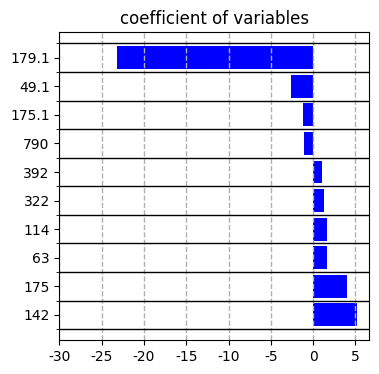

In [11]:
x_pos = np.arange(len(chart))

fig = plt.figure(figsize=(4,4))
ax1 = fig.add_subplot(1, 1, 1)
ax1.barh(x_pos, chart['standard_regression_coefficients'], color='b')
ax1.set_title('coefficient of variables')
ax1.set_yticks(x_pos)
ax1.set_yticks(np.arange(-1,len(chart.index))+0.5, minor=True)
ax1.set_yticklabels(chart.index)
ax1.set_xticks(np.arange(-30,10,5))
ax1.set_xticklabels(np.arange(-30,10,5))
ax1.grid(which='minor',axis='y',color='black',linestyle='-', linewidth=1)
ax1.grid(which='major',axis='x',linestyle='--', linewidth=1)
plt.show()